In [35]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt


nginx = {
    "name": "Nginx",
    "ip": "nginx.antoniszczepanik.com",
}

h2o = {
    "name": "H2O",
    "ip": "h2o.antoniszczepanik.com",
}

caddy = {
    "name": "Caddy",
    "ip": "caddy.antoniszczepanik.com",
}

ls = {
    "name": "OpenLiteSpeed",
    "ip": "litespeed.antoniszczepanik.com",
}

iperf_port = "6969"

servers = (nginx, h2o, caddy, ls)

## Bandwidth and latency test

### Latency

In [2]:
for server in servers:
    print("")
    print(f"==================== PING {server['name']} ==========================")
    !ping -c 5 {server["ip"]}


==================== PING nginx ==========================
PING nginx.antoniszczepanik.com (18.159.234.10) 56(84) bytes of data.
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=1 ttl=63 time=0.238 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=2 ttl=63 time=0.282 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=3 ttl=63 time=0.239 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=4 ttl=63 time=0.254 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=5 ttl=63 time=0.246 ms

--- nginx.antoniszczepanik.com ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4071ms
rtt min/avg/max/mdev = 0.238/0.251/0.282/0.016 ms

==================== PING h2o ==========================
PING h2o.antoniszczepanik.com (3.72.136.224) 56(84) bytes of data.


### Bandwidth - TCP & UDP

In [3]:
# TODO: Make sure iperf is running on all servers.
!iperf -c {nginx["ip"]} -p {iperf_port}
!iperf -u -c {nginx["ip"]} -p {iperf_port} -b 0

Connecting to host nginx.antoniszczepanik.com, port 6969
[  5] local 172.31.34.118 port 44278 connected to 18.159.234.10 port 6969
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-1.00   sec   458 MBytes  3.84 Gbits/sec  2004    294 KBytes       
[  5]   1.00-2.00   sec   551 MBytes  4.62 Gbits/sec  3362    235 KBytes       
[  5]   2.00-3.00   sec   562 MBytes  4.72 Gbits/sec  3147    269 KBytes       
[  5]   3.00-4.00   sec   564 MBytes  4.73 Gbits/sec  2144    308 KBytes       
[  5]   4.00-5.00   sec   561 MBytes  4.71 Gbits/sec  1129    252 KBytes       
[  5]   5.00-6.00   sec   562 MBytes  4.72 Gbits/sec  936    242 KBytes       
[  5]   6.00-7.00   sec   561 MBytes  4.71 Gbits/sec  1316    273 KBytes       
[  5]   7.00-8.00   sec   564 MBytes  4.73 Gbits/sec  2520    247 KBytes       
[  5]   8.00-9.00   sec   564 MBytes  4.73 Gbits/sec  1586    600 KBytes       
[  5]   9.00-10.00  sec   564 MBytes  4.73 Gbits/sec   84    817 KBytes       
- - - 

### Measuring QUIC performance

#### h2 load output parsing

In [4]:
def get_throughput(res):
    fin_line = [l for l in res if l.startswith("finished in ")][0]
    return float(fin_line.split(" ")[-1][:-4])

def get_rps(res):
    fin_line = [l for l in res if l.startswith("finished in ")][0]
    return float(fin_line.split(" ")[3])

def get_success_pct(res):
    req_line = [l for l in res if l.startswith("requests:")][0]
    items = req_line.split(" ")
    return float(items[7])/float(items[1])

#### Bulk Throughput

Get throughput measurment from the client.

In [33]:
data_tp = {
    "server": [],
    "throughput": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3",):
        print(f"bulk throughput test {protocol} - {server['name']}")
        # Request the file first, just to warm up caches.
        _ = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/1g.txt
        for i in range(10):
            res = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/1g.txt
            data_tp['server'].append(server['name'])
            data_tp['throughput'].append(get_throughput(res))
            data_tp['protocol'].append("HTTP/2" if protocol == "h2" else "HTTP/3")
            print(f"{get_throughput(res)} MB/s (succ: {get_success_pct(res)})")

bulk throughput test h2 - Nginx
492.72 MB/s (succ: 1.0)
551.13 MB/s (succ: 1.0)
454.62 MB/s (succ: 1.0)
461.7 MB/s (succ: 1.0)
559.34 MB/s (succ: 1.0)
560.43 MB/s (succ: 1.0)
441.88 MB/s (succ: 1.0)
544.52 MB/s (succ: 1.0)
413.55 MB/s (succ: 1.0)
526.93 MB/s (succ: 1.0)
bulk throughput test h3 - Nginx
129.09 MB/s (succ: 1.0)
132.4 MB/s (succ: 1.0)
153.08 MB/s (succ: 1.0)
147.3 MB/s (succ: 1.0)
150.81 MB/s (succ: 1.0)
153.39 MB/s (succ: 1.0)
150.79 MB/s (succ: 1.0)
156.36 MB/s (succ: 1.0)
124.1 MB/s (succ: 1.0)
150.49 MB/s (succ: 1.0)
bulk throughput test h2 - H2O
456.84 MB/s (succ: 1.0)
500.62 MB/s (succ: 1.0)
540.13 MB/s (succ: 1.0)
548.56 MB/s (succ: 1.0)
496.77 MB/s (succ: 1.0)
505.91 MB/s (succ: 1.0)
512.8 MB/s (succ: 1.0)
492.13 MB/s (succ: 1.0)
556.45 MB/s (succ: 1.0)
557.43 MB/s (succ: 1.0)
bulk throughput test h3 - H2O
265.68 MB/s (succ: 1.0)
249.15 MB/s (succ: 1.0)
267.37 MB/s (succ: 1.0)
271.65 MB/s (succ: 1.0)
220.8 MB/s (succ: 1.0)
215.21 MB/s (succ: 1.0)
268.62 MB/s (succ:

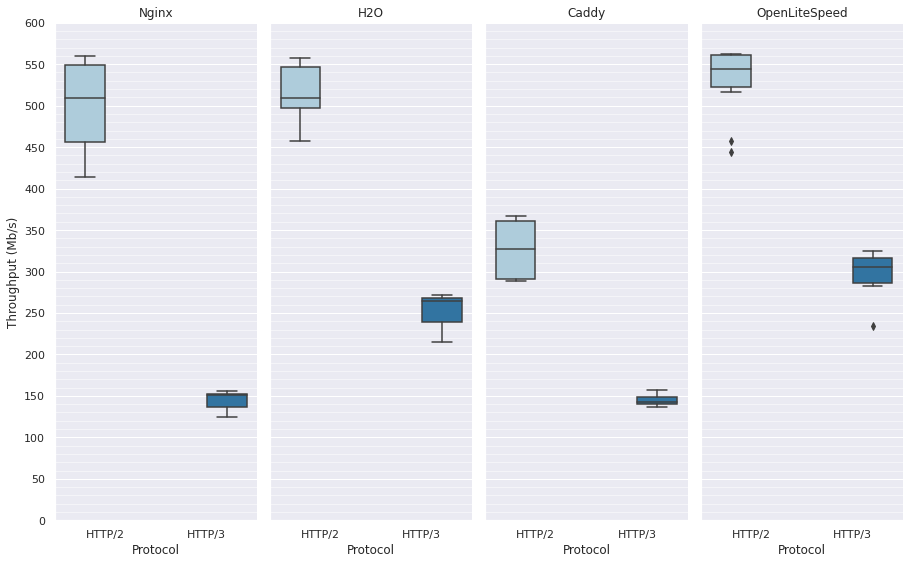

In [51]:
def get_title_from_subplot(sup_title):
    for s in servers:
        if s['name'].lower() in sup_title.lower():
            return s['name']
    return "ERROR: unknown server"

df_tp = pd.DataFrame(data_tp)
sns.set(rc={'figure.figsize':(30,10)})

# ax = sns.boxplot(x="server", y="throughput", hue="protocol", data=df_tp, palette="Set3")

g = sns.catplot(x="protocol", y="throughput",hue="protocol", col="server",data=df_tp, kind="box",height=8, aspect=.4, palette="Paired");
g.set_xlabels('Protocol')
g.set_ylabels('Throughput (Mb/s)')
for p in g.axes.flatten():
    p.set_title(get_title_from_subplot(str(p.title)))
    p.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    p.grid(visible=True, which='minor', color='w', linewidth=0.5)
    plt.yticks(list(range(0, 601, 50)))

In [63]:
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for i in range(10):
            res = !h2load -n1000000 -t $(nproc) -c 100 -m 100 --npn-list={protocol} https://{server['ip']}/index.html
            data_rps['server'].append(server['name'])
            data_rps['rps'].append(get_rps(res))
            data_rps['protocol'].append(protocol)
            print(f"{get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")

rps test h2 - Nginx
47921.09 req/s (succ: 1.000)
51278.58 req/s (succ: 1.000)
49197.36 req/s (succ: 1.000)
49607.89 req/s (succ: 1.000)
49386.83 req/s (succ: 1.000)
50206.35 req/s (succ: 1.000)
49112.86 req/s (succ: 1.000)
48425.56 req/s (succ: 1.000)
49369.1 req/s (succ: 1.000)
48114.32 req/s (succ: 1.000)
rps test h3 - Nginx
76311.07 req/s (succ: 1.000)
77807.87 req/s (succ: 1.000)
75372.46 req/s (succ: 1.000)
77216.2 req/s (succ: 1.000)
76931.45 req/s (succ: 1.000)
76066.0 req/s (succ: 1.000)
75937.59 req/s (succ: 1.000)
75892.46 req/s (succ: 1.000)
69980.02 req/s (succ: 1.000)
76678.88 req/s (succ: 1.000)
rps test h2 - H2O
224793.91 req/s (succ: 1.000)
245080.26 req/s (succ: 1.000)
238039.53 req/s (succ: 1.000)
242201.36 req/s (succ: 1.000)
239886.56 req/s (succ: 1.000)
245398.05 req/s (succ: 1.000)
238321.87 req/s (succ: 1.000)
245430.09 req/s (succ: 1.000)
236441.05 req/s (succ: 1.000)
236446.81 req/s (succ: 1.000)
rps test h3 - H2O
148349.53 req/s (succ: 1.000)
139490.11 req/s (

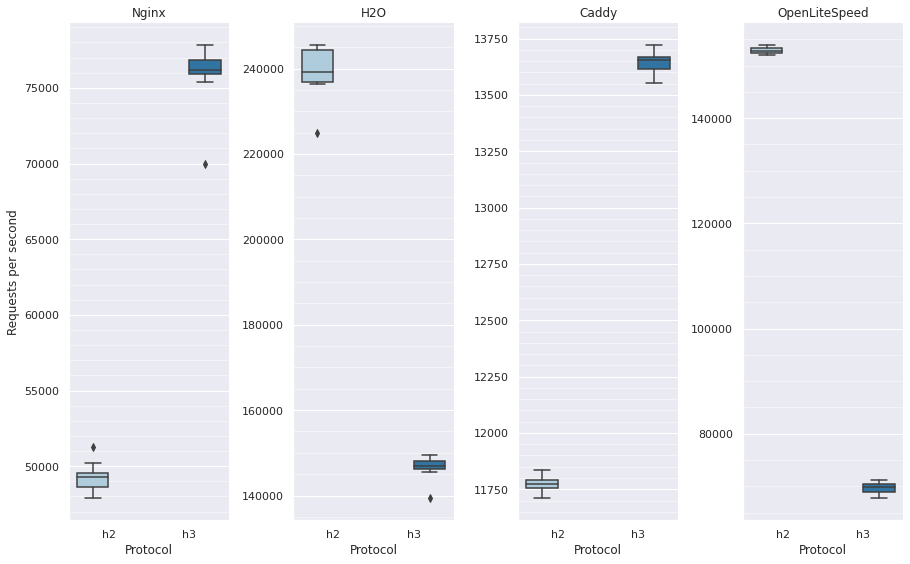

In [ ]:
df_rps= pd.DataFrame(data_rps)
sns.set(rc={'figure.figsize':(20,10)})


g = sns.catplot(x="protocol", y="rps",hue="protocol", col="server",data=df_rps, kind="box",height=8, aspect=.4, palette="Paired", sharey=False);
g.set_xlabels('Protocol')
g.set_ylabels('Requests per second')
for p in g.axes.flatten():
    p.set_title(get_title_from_subplot(str(p.title)))
    p.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    p.grid(visible=True, which='minor', color='w', linewidth=0.5)

In [ ]:
# RPS with single connection (vary multiplexing level)

In [61]:
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for i in range(5):
            res = !h2load -n100000 -t $(nproc) -c 100 -m 1 --npn-list={protocol} https://{server['ip']}/index.html
            data_rps['server'].append(server['name'])
            data_rps['rps'].append(get_rps(res))
            data_rps['protocol'].append(protocol)
            print(f"{get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")

rps test h2 - Nginx
32746.68 req/s (succ: 1.000)
36969.23 req/s (succ: 1.000)
30660.96 req/s (succ: 1.000)
38049.64 req/s (succ: 1.000)
38005.42 req/s (succ: 1.000)
rps test h3 - Nginx
3855.15 req/s (succ: 1.000)
3844.79 req/s (succ: 1.000)
3820.27 req/s (succ: 1.000)
3844.66 req/s (succ: 1.000)
3847.53 req/s (succ: 1.000)
rps test h2 - H2O
56812.6 req/s (succ: 1.000)
55374.7 req/s (succ: 1.000)
57174.78 req/s (succ: 1.000)
57726.22 req/s (succ: 1.000)
56773.09 req/s (succ: 1.000)
rps test h3 - H2O
3861.18 req/s (succ: 1.000)
3835.43 req/s (succ: 1.000)
3851.58 req/s (succ: 1.000)
3843.74 req/s (succ: 1.000)
3840.83 req/s (succ: 1.000)
rps test h2 - Caddy
8847.96 req/s (succ: 1.000)
9124.59 req/s (succ: 1.000)
8977.37 req/s (succ: 1.000)
9273.31 req/s (succ: 1.000)
9171.58 req/s (succ: 1.000)
rps test h3 - Caddy
7807.05 req/s (succ: 1.000)
7805.01 req/s (succ: 1.000)
7520.6 req/s (succ: 1.000)
7809.15 req/s (succ: 1.000)
7810.76 req/s (succ: 1.000)
rps test h2 - OpenLiteSpeed
43515.61 